# BF Chromaticity

The data is based on AuxTel data from the night of 2023-08-03.
https://roundtable.lsst.codes/rubintv/summit/auxtel/historical/2023-08-03


In [11]:
import os
import numpy as np
import glob
from astropy.io import fits
import pickle as pkl
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
from lsst.obs.lsst import Latiss
camera = Latiss().getCamera()
from matplotlib.pyplot import cm
from scipy import stats
from scipy import interpolate
import matplotlib.ticker as mticker

def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')

def get_astropy_wcs(image):
    from astropy.wcs import WCS
    print(image.getWcs())
    
    wcs_dict = dict()
    for val in image.getWcs().getFitsMetadata():
        wcs_dict[str(val)] = image.getWcs().getFitsMetadata()[str(val)]

    return WCS(wcs_dict)

def get_astropy_wcs_from_image(image):
    from astropy.wcs import WCS
    
    wcs_dict = dict()
    for val in image.getWcs().getFitsMetadata():
        wcs_dict[str(val)] = image.getWcs().getFitsMetadata()[str(val)]

    return WCS(wcs_dict)

def get_astropy_wcs_from_image_file(image_fits):
    from astropy.wcs import WCS
    hdu = fits.open(image_fits)
    wcs = WCS(hdu['SkyWcs'].header)
    hdu.close()
    
    return wcs
    


def find_stars_on_sky(image):
    from astropy.stats import sigma_clipped_stats
    from photutils.datasets import load_star_image
    from photutils.detection import DAOStarFinder
    from astropy.wcs import WCS

    data = image.getImage().getArray()
    wcs = get_astropy_wcs_from_image(image)
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)   

    daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
    sources = daofind(data - median)  

    for col in sources.colnames:  
        if col not in ('id', 'npix'):
            sources[col].info.format = '%.2f'  # for consistent table output

    sky_coords = [wcs.pixel_to_world(source['xcentroid'], source['ycentroid']).transform_to('galactic') for source in sources]
    
    sources.add_columns([[c.l for c in sky_coords], [c.b for c in sky_coords]], names=['l (deg)', 'b (deg)'])
    
    #sources.pprint(max_width=76)  
    
    return sources 


def get_2nd_mom_from_hsm_result(results):
    # Calculate Second Moments
    e1 = results.observed_shape.e1
    e2 = results.observed_shape.e2
    sigma = results.moments_sigma
    sigma_ave = sigma / (1 - e1**2 - e2**2 )**(0.25) 
    Ixx = (1+e1) * sigma_ave**2
    Iyy = (1-e1) * sigma_ave**2
    Ixy = e2 * (sigma_ave**2) 
    
    return Ixx, Iyy, Ixy


def get_star_stats(src,imageobj, ind, showSpot=True):
    import galsim
    
    image = imageobj.getImage().getArray()
    
    result = np.zeros((1, 4))
    star = src[ind]
    y = star['base_SdssCentroid_x']
    x = star['base_SdssCentroid_y']
    #r = np.sqrt(star['npix']/np.pi)
    s = 40

    xmin = int(max(0,x-s))
    xmax = int(min(image.shape[0]-1, x+s+1))
    ymin = int(max(0,y-s))
    ymax = int(min(image.shape[1]-1, y+s+1))
    stamp = galsim.Image(image[xmin:xmax,ymin:ymax])

    if showSpot:
        plt.imshow(image[xmin:xmax,ymin:ymax])

    try:
        res = galsim.hsm.FindAdaptiveMom(stamp)
        ixx,iyy,ixy = get_2nd_mom_from_hsm_result(res)
        result = [np.max(image[xmin:xmax,ymin:ymax]),ixx,iyy,ixy,res.moments_sigma,res.moments_amp]
    except:
        result = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
        
    
    return stamp.array,result
    

##### First we are going to setup a butler to repository where the LATISS data is ingested on USDF.<br>Here wea re just going to pull some raw images from a specific date and time.

##### You can look up on Rubin TV to check which date, or copy the dataID for a specific exposure.<br>
https://roundtable.lsst.codes/rubintv/summit/auxtel/historical/2023-05-23

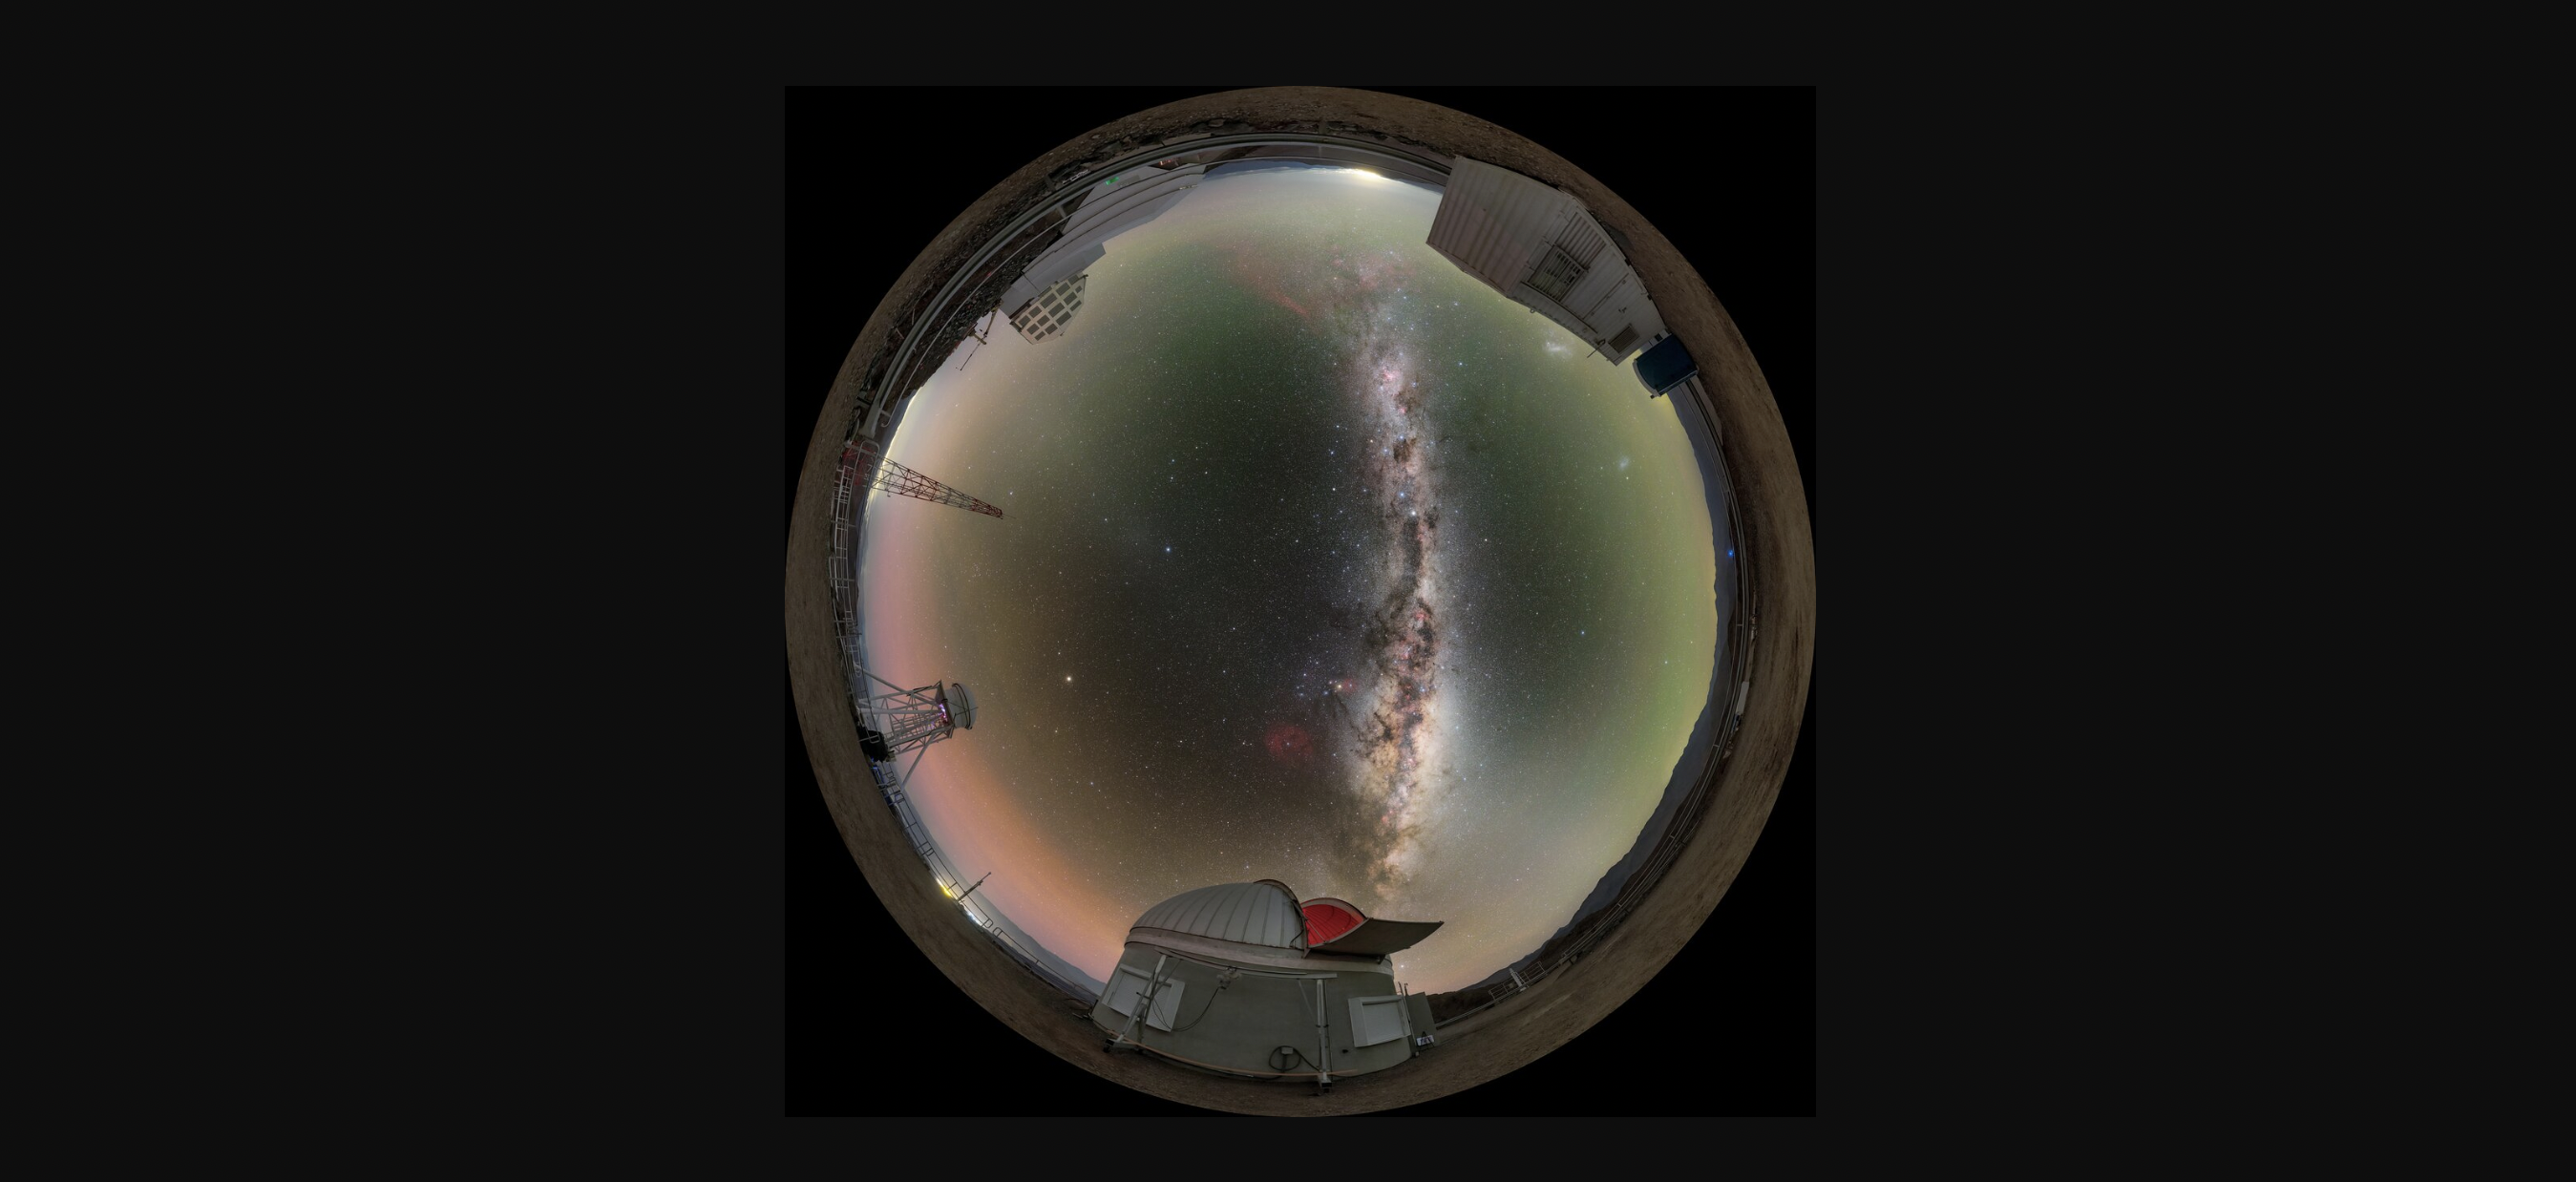

In [12]:
repo = "/repo/embargo"
butler = Butler(repo)
registry = butler.registry

for c in registry.queryCollections("u/abrought/*"):
    print(c)    

u/abrought/latiss/defects.2023.08.03
u/abrought/latiss/defects.2023.08.03/20230818T225957Z
u/abrought/latiss/dark.2023.08.03/20230819T173437Z
u/abrought/latiss/stars.SDSSr_65mm.2023.08.03
u/abrought/latiss/stars.SDSSr_65mm.2023.08.03/20230820T170142Z
u/abrought/latiss/defects.2023.08.03/20230818T235959Z
u/abrought/latiss/sflat.SDSSg_65mm.2023.08.03
u/abrought/latiss/sflat.SDSSg_65mm.2023.08.03/20230819T200827Z
u/abrought/latiss/stars.SDSSi_65mm.2023.08.03
u/abrought/latiss/stars.SDSSi_65mm.2023.08.03/20230820T173039Z
u/abrought/latiss/dark.2023.08.03
u/abrought/latiss/dark.2023.08.03/20230819T052447Z
u/abrought/latiss/sflat.SDSSr_65mm.2023.08.03
u/abrought/latiss/sflat.SDSSr_65mm.2023.08.03/20230819T202611Z
u/abrought/latiss/sflat.SDSSi_65mm.2023.08.03
u/abrought/latiss/sflat.SDSSi_65mm.2023.08.03/20230819T203131Z
u/abrought/latiss/stars.2023.08.03
u/abrought/latiss/stars.2023.08.03/20230819T230924Z
u/abrought/latiss/sbias.2023.08.03
u/abrought/latiss/sbias.2023.08.03/20230816T001936Z


The collections:
-   $\texttt{u/abrought/latiss/stars.2023.08.03}$ is in SDSS $\textit{g}$-band


In [23]:
subbutler = Butler(repo,collections=['u/abrought/latiss/stars.2023.08.03'])
subregistry = subbutler.registry
ref_index = 101
refs = list(subregistry.queryDatasets(datasetType='postISRCCD', collections=['u/abrought/latiss/stars.2023.08.03'])) 
print(len(refs))
image = subbutler.get('postISRCCD',dataId = refs[ref_index].dataId, collections=['u/abrought/latiss/stars.2023.08.03'])
catalog = subbutler.get('spotSrc',dataId = refs[ref_index].dataId, collections=['u/abrought/latiss/stars.2023.08.03'])

133


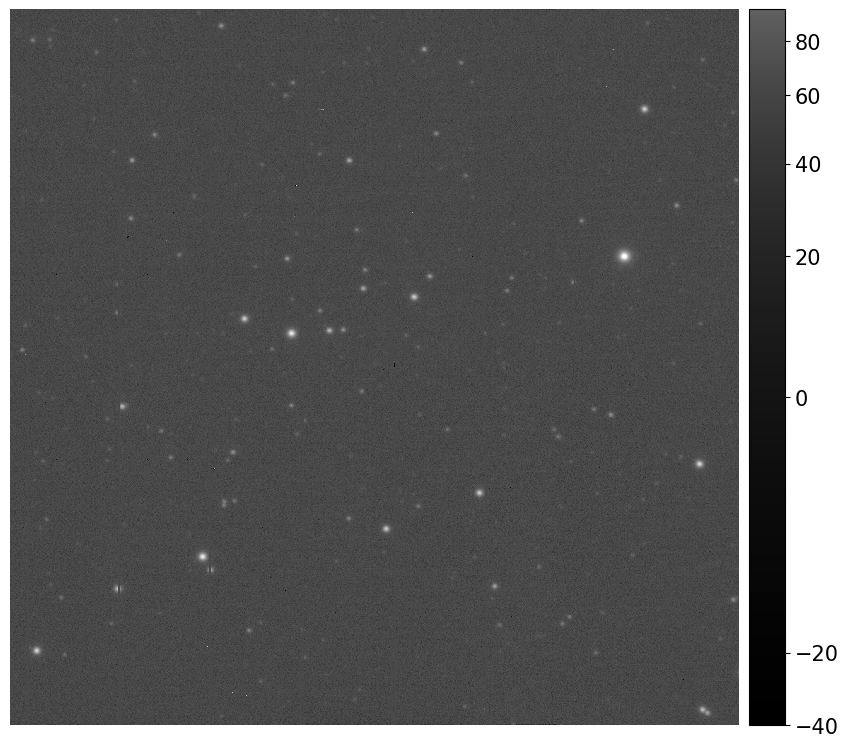

In [24]:
display(image)

# TEST

In [46]:
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.algorithms.subtractBackground import SubtractBackgroundTask

In [37]:
config = SubtractBackgroundTask.ConfigClass()
task = SubtractBackgroundTask(config=config)

res = task.run(exposure=image)


In [45]:
config = SourceDetectionTask.ConfigClass()
task = SourceDetectionTask(config=config)

res = task.run(table=data, exposure=image)

TypeError: lsst.afw.table._table.SourceTable: No constructor defined!

# Continued

In [26]:

def fill_catalog(refs):
    output = np.array([np.nan, np.nan, np.nan,np.nan,np.nan,np.nan])
    for n,r in enumerate(refs):
        print(f"{n+1}/{len(refs)}")
        image = subbutler.get('postISRCCD',dataId = r.dataId, collections=['u/abrought/latiss/stars.2023.08.03'])
        catalog = subbutler.get('spotSrc',dataId = r.dataId, collections=['u/abrought/latiss/stars.2023.08.03'])
        
        mask = (catalog['base_SdssCentroid_flag_near_edge']==False) * (catalog['base_CircularApertureFlux_flag_badCentroid']==False) * (catalog['base_SdssShape_instFlux'] > 2e5)
        
        for i,star in enumerate(catalog[mask]):
            _,result = get_star_stats(catalog[mask],image, i, showSpot=False)
            output = np.vstack((output,result))
        del image
        del catalog
        
    return output

In [27]:
output = fill_catalog(refs)

1/133
2/133
3/133
4/133
5/133
6/133
7/133
8/133
9/133
10/133
11/133
12/133
13/133
14/133
15/133
16/133
17/133
18/133
19/133
20/133
21/133
22/133
23/133
24/133
25/133
26/133
27/133
28/133
29/133
30/133
31/133
32/133
33/133
34/133
35/133
36/133
37/133
38/133
39/133
40/133
41/133
42/133
43/133
44/133
45/133
46/133
47/133
48/133
49/133
50/133
51/133
52/133
53/133
54/133
55/133
56/133
57/133
58/133
59/133
60/133
61/133
62/133
63/133
64/133
65/133
66/133
67/133
68/133
69/133
70/133
71/133
72/133
73/133
74/133
75/133
76/133
77/133
78/133
79/133
80/133
81/133
82/133
83/133
84/133
85/133
86/133
87/133
88/133
89/133
90/133
91/133
92/133
93/133
94/133
95/133
96/133
97/133
98/133
99/133
100/133
101/133
102/133
103/133
104/133
105/133
106/133
107/133
108/133
109/133
110/133
111/133
112/133
113/133
114/133
115/133
116/133
117/133
118/133
119/133
120/133
121/133
122/133
123/133
124/133
125/133
126/133
127/133
128/133
129/133
130/133
131/133
132/133
133/133


In [28]:
np.save("./output_g.npy",output)

In [29]:
output_g = np.load("./output_g.npy")
output_r = np.load("./output_r.npy")
output_i = np.load("./output_i.npy")

(0.0, 300.0)

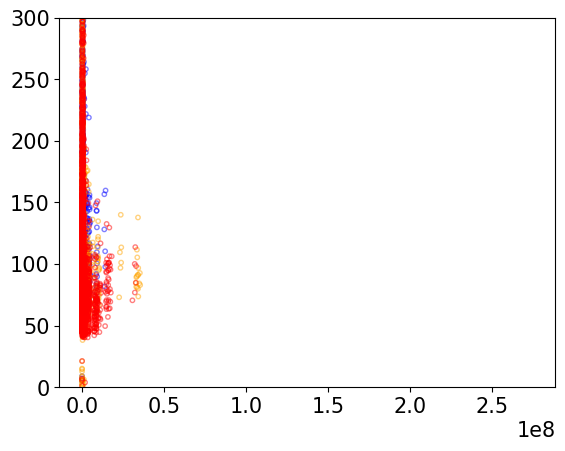

In [44]:
plt.scatter(output_g[:,5], 2*output_g[:,4]**2, marker="o", s=10, facecolor="None", edgecolor="b", alpha=0.5)
plt.scatter(output_r[:,5], 2*output_r[:,4]**2, marker="o", s=10, facecolor="None", edgecolor="orange", alpha=0.5)
plt.scatter(output_i[:,5], 2*output_i[:,4]**2, marker="o", s=10, facecolor="None", edgecolor="r", alpha=0.5)
#plt.xlim(0,1.0e7)
plt.ylim(0,300)

In [46]:
mask = (output_r[:,5] > 0.2e7) * (output_r[:,5] < 0.5e8)

m,b =np.polyfit(output_r[:,5][mask], 2*output_r[:,4][mask]**2, deg=1)
print(m,b)

3.3908937118919264e-07 84.8021709468169


In [ ]:
g 1.0733059692759992e-06 101.23935443750533
r 3.3908937118919264e-07 84.8021709468169
i 2.8646648289784597e-07

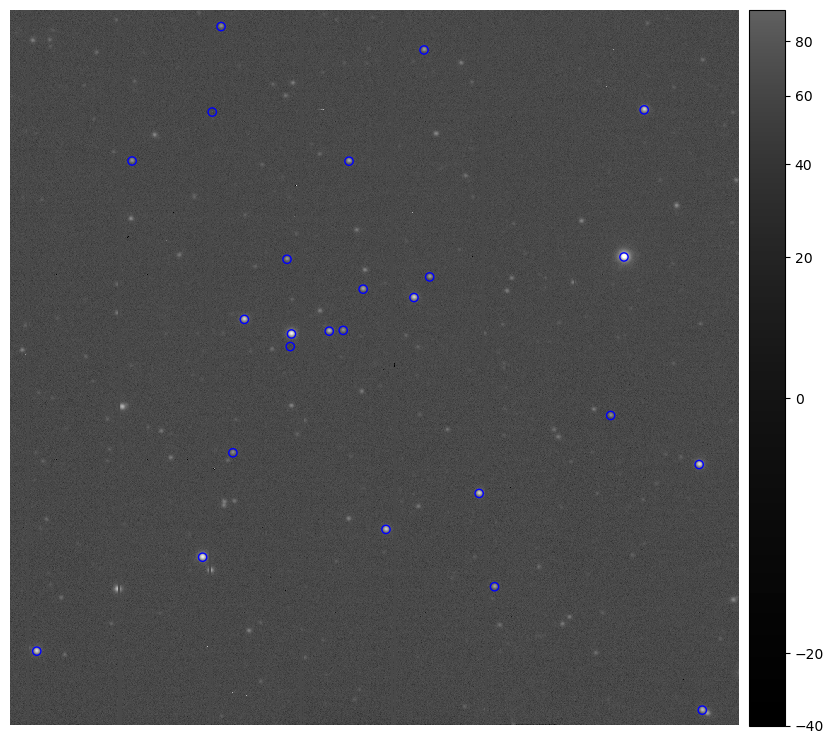

In [ ]:
display(image)
mask = (catalog['base_SdssCentroid_flag_near_edge']==False) * (catalog['base_CircularApertureFlux_flag_badCentroid']==False) * (catalog['base_SdssShape_instFlux'] > 2e5)
plt.scatter(catalog[mask]['base_SdssCentroid_x'], catalog[mask]['base_SdssCentroid_y'], color='blue', facecolor="None")

In [67]:
def get_star_stats(src,imageobj, ind, showSpot=True):
    import galsim
    
    image = imageobj.getImage().getArray()
    
    result = np.zeros((1, 4))
    star = src[ind]
    y = star['base_SdssCentroid_x']
    x = star['base_SdssCentroid_y']
    #r = np.sqrt(star['npix']/np.pi)
    s = 40

    xmin = int(max(0,x-s))
    xmax = int(min(image.shape[0]-1, x+s+1))
    ymin = int(max(0,y-s))
    ymax = int(min(image.shape[1]-1, y+s+1))
    stamp = galsim.Image(image[xmin:xmax,ymin:ymax])

    if showSpot:
        plt.imshow(image[xmin:xmax,ymin:ymax])

    try:
        res = galsim.hsm.FindAdaptiveMom(stamp)
        ixx,iyy,ixy = get_2nd_mom_from_hsm_result(res)
        print(ixx,iyy,ixy)
        result = [np.max(image[ymin:ymax,xmin:xmax]),ixx,iyy,ixy]
    except:
        result = [np.nan,np.nan,np.nan,np.nan]
        
    
    return stamp.array,result

63.79713630314087 52.929340759642905 -2.923487890527622


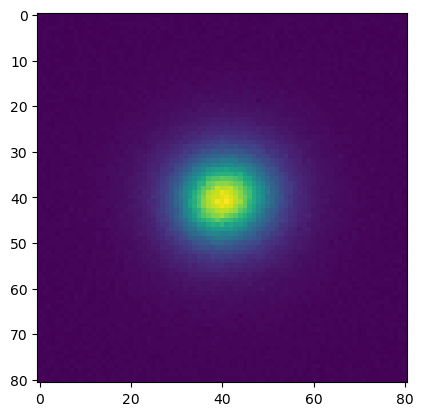

In [73]:
stamp,result = get_star_stats(catalog[mask],image, 14)

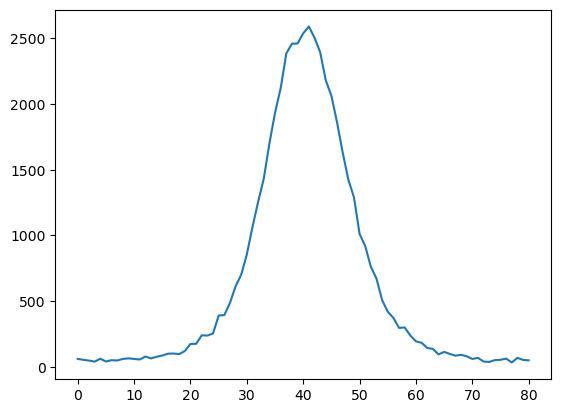

In [74]:
plt.plot(stamp[40,:])

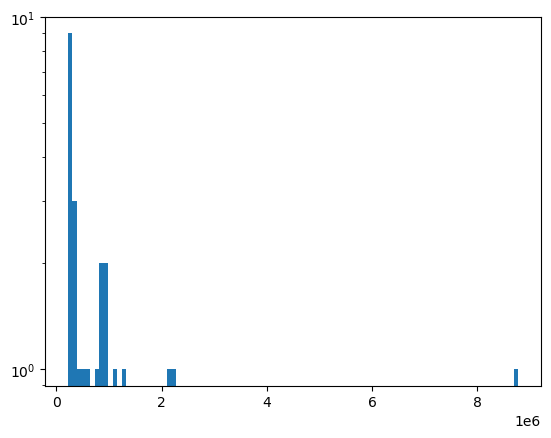

In [55]:
_ = plt.hist(catalog[mask]['base_SdssShape_instFlux'], bins=100)
plt.yscale('log')

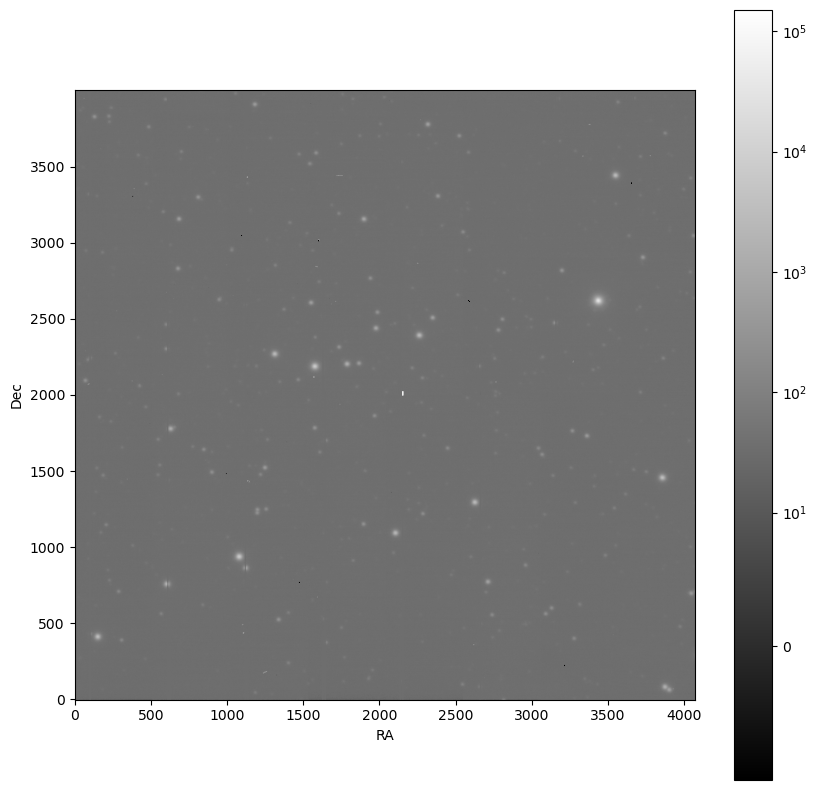

In [56]:

fig = plt.figure(figsize=(10, 10))
from matplotlib.colors import SymLogNorm
plt.imshow(image.getImage().getArray(), origin='lower', norm=SymLogNorm(10, vmin=-10, vmax=150000, base=10),cmap='binary_r', aspect='equal')

plt.xlabel(r'RA')
plt.ylabel(r'Dec')

plt.colorbar()


In [11]:
ref = refs[0]
raw=butler.get('raw',dataId = ref.dataId, collections=collections)

exptime = raw.getMetadata()['EXPTIME']

display(raw)

NameError: name 'collections' is not defined

In [12]:
def isr(raw, bias, dark, defects):
    from lsst.ip.isr.isrTask import IsrTask

    config = IsrTask.ConfigClass()
    config.doDark = True
    config.doBias = True
    config.doFlat = False
    config.doDefect = True
    config.doLinearize=False
    config.doBrighterFatter=False
    config.doApplyGains=False
    config.doOverscan=True
    # The images tend to have serial structure ("banding"), 
    # and this is the best option to remove it.
    config.overscan.fitType='MEDIAN_PER_ROW' 

    isrtask = IsrTask(config=config) # default configuration
    
    postISRStruct = isrtask.run( raw, 
                                camera=camera, 
                                bias=bias, 
                                dark=dark,
                                defects=defects,
                                detectorNum=0)
    # Note: the task returns a struct that contains the exposure object
    image = postISRStruct.exposure
    
    return image

def isr_all(raw_image_list):
    # Get calibrated collections
    collections = "LATISS/calib"
    bias = butler.get('bias',dataId = {"day_obs": 20230131, "seq_num": 151, "detector": 0},instrument='LATISS', collections=collections)
    dark = butler.get('dark',dataId = {"day_obs": 20230523, "seq_num": 45, "detector": 0},instrument='LATISS', collections=collections)
    defects = butler.get('defects',dataId = {"day_obs": 20230523, "seq_num": 45, "detector": 0},instrument='LATISS', collections=collections)
    
    return [isr(raw,bias,dark,defects) for raw in raw_image_list]

In [13]:
corrected_images = isr_all(raw_images)

In [ ]:
display(corrected_images[9])

FITS standard SkyWcs:
Sky Origin: (240.0097368719, -23.9854066887)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel


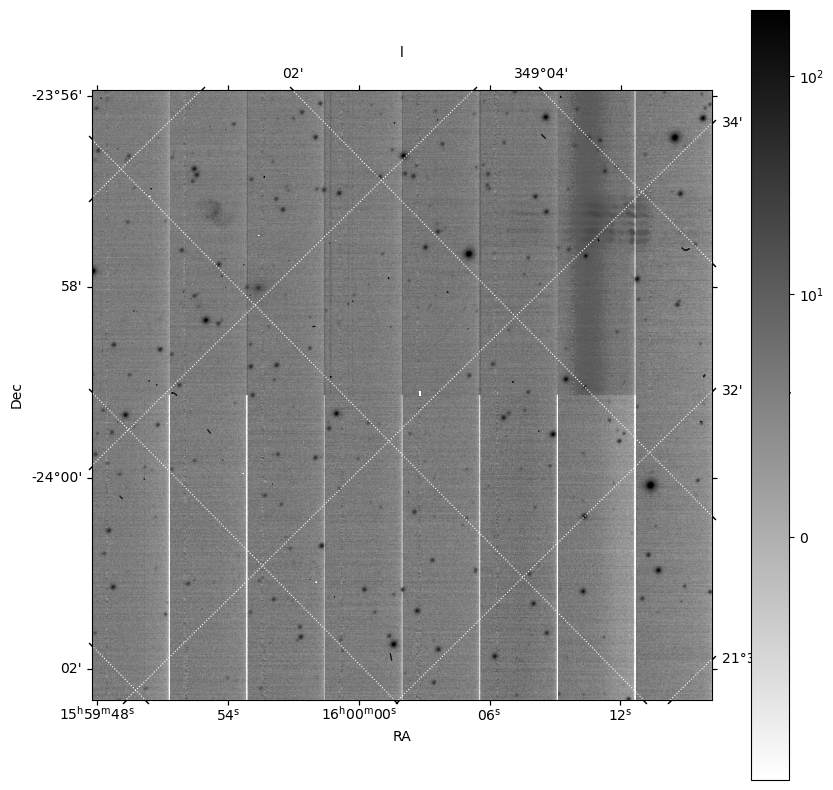

In [26]:
wcs = get_astropy_wcs(corrected_images[0])
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs)
from matplotlib.colors import SymLogNorm
plt.imshow(corrected_images[0].getImage().getArray(), origin='lower', cmap='binary', norm=SymLogNorm(10, vmin=-10, vmax=200, base=10), aspect='equal')
plt.xlabel(r'RA')
plt.ylabel(r'Dec')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.colorbar()
overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='white', ls='dotted')

1. Identify sources in each image
2. Gernate catalog for each image
3. Compare multiple catalogs for repeated images of the same object within some tolerance

In [14]:
def write_image_to_file(image, pathname):
    image.writeFits(pathname)
    return f"{pathname}.fits"

In [15]:
for i in range(len(corrected_images)):
    write_image_to_file(corrected_images[i], f"./corrected_image_{i}.fits") 

In [28]:
image = corrected_images[0]

In [29]:
image.visitInfo

VisitInfo(exposureTime=30, darkTime=30.2394, date=2023-08-03T23:34:30.832491506, UT1=nan, ERA=5.33128 rad, boresightRaDec=(270.1609775124, -25.0446011813), boresightAzAlt=(89.4147817911, +58.1889706304), boresightAirmass=1.17584, boresightRotAngle=2.15931e-05 rad, rotType=1, observatory=30.2448N, -70.7477E  2663.01, weather=Weather(nan, nan, nan), instrumentLabel='LATISS', id=2023080300297, focusZ=-0.0211924, observationType='science', scienceProgram='AUXTEL_PHOTO_IMAGING', observationReason='object', object='Photo1800-1_002', hasSimulatedContent=false)

In [30]:
#del corrected_images

In [26]:
def find_stars_in_image(image_fits):
    from astropy.stats import sigma_clipped_stats
    from photutils.datasets import load_star_image
    from photutils.detection import DAOStarFinder

    hdu = fits.open(image_fits)
    data = hdu[1].data
    mean, median, std = sigma_clipped_stats(data, sigma=3.0) 
    
    print(median)

    daofind = DAOStarFinder(fwhm=10.0, threshold=5.*std)  
    sources = daofind(data - median)  

    for col in sources.colnames:  
        if col not in ('id', 'npix'):
            sources[col].info.format = '%.2f'  # for consistent table output
    
    #sources.pprint(max_width=76)  
    
    return sources

In [15]:
srcs = find_stars_in_image("./corrected_image_0.fits")

In [22]:
def remove_blended_sources(src):
    import itertools

    combinations = list(itertools.combinations(range(0,len(src)-1), 2))
    print(len(src), np.min(range(0,len(src))), np.max(range(0,len(src))))
    bad = []
    for pair in combinations:
        (i,j) = src[pair[0]], src[pair[1]]
        good = np.sqrt((i['xcentroid'] - j['xcentroid'])**2 + (i['ycentroid'] - j['ycentroid'])**2) > 5*np.sqrt(i['npix']/np.pi)
        
        if not good:
            bad.extend(pair)

    return np.delete(src, np.unique(bad))

FITS standard SkyWcs:
Sky Origin: (240.0097368719, -23.9854066887)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel
121 0 120


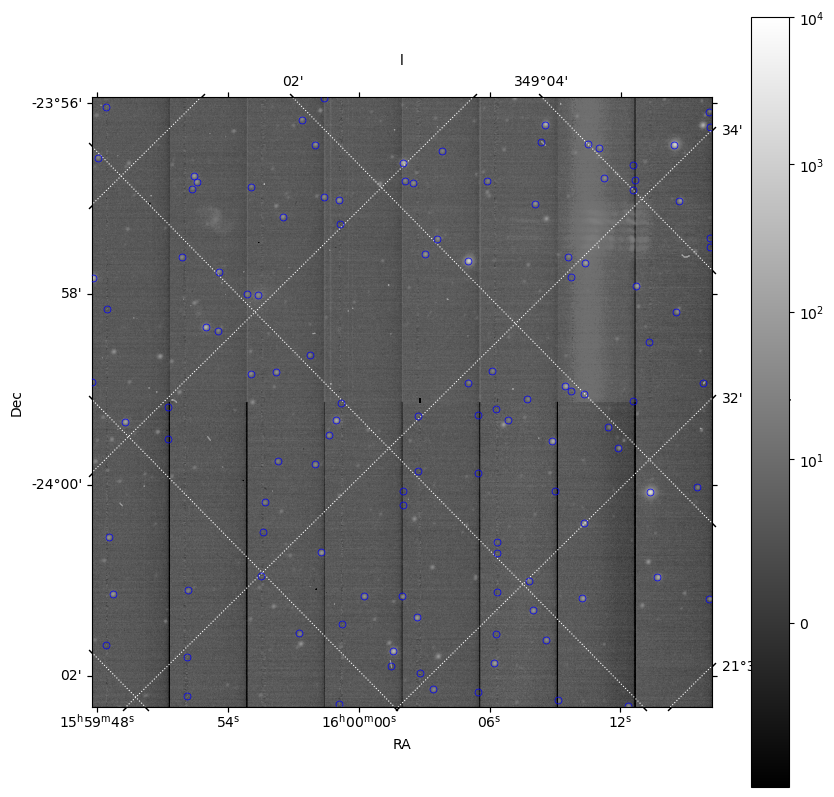

In [17]:
wcs = get_astropy_wcs(corrected_images[0])
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs)
from matplotlib.colors import SymLogNorm
plt.imshow(corrected_images[0].getImage().getArray(), origin='lower', cmap='binary_r', norm=SymLogNorm(10, vmin=-10, vmax=10000, base=10), aspect='equal')
src = remove_blended_sources(srcs)
plt.plot(src['xcentroid'], src['ycentroid'], "bo", markerfacecolor='None', markeredgewidth=0.5,markersize=5)
plt.xlabel(r'RA')
plt.ylabel(r'Dec')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.colorbar()
overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='white', ls='dotted')

FITS standard SkyWcs:
Sky Origin: (240.0097368719, -23.9854066887)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel
121 0 120


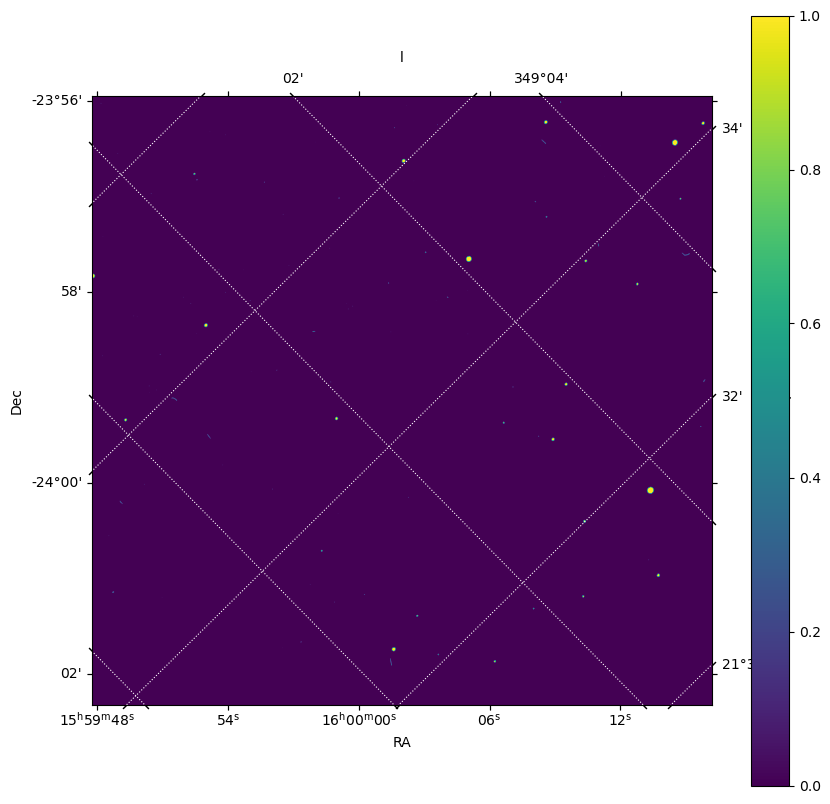

In [18]:
wcs = get_astropy_wcs(corrected_images[0])
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs)
from matplotlib.colors import SymLogNorm
#plt.imshow(corrected_images[0].getImage().getArray(), origin='lower', cmap='binary', norm=SymLogNorm(10, vmin=-10, vmax=120000, base=10), aspect='equal')
src = remove_blended_sources(srcs)
thresh = 80.
mask = (corrected_images[0].getImage().getArray() > thresh)
plt.imshow(mask)
plt.xlabel(r'RA')
plt.ylabel(r'Dec')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.colorbar()
overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='white', ls='dotted')

In [20]:
def get_2nd_mom_from_hsm_result(results):
    # Calculate Second Moments
    e1 = results.observed_shape.e1
    e2 = results.observed_shape.e2
    sigma = results.moments_sigma
    sigma_ave = sigma / (1 - e1**2 - e2**2 )**(0.25) 
    Ixx = (1+e1) * sigma_ave**2
    Iyy = (1-e1) * sigma_ave**2
    Ixy = e2 * (sigma_ave**2) 
    
    return Ixx, Iyy, Ixy

def get_star_stats(src,imageobj):
    import galsim
    
    image = imageobj.getImage().getArray()
    
    result = np.zeros((len(src), 4))
    for i, star in enumerate(src):
        x = star['xcentroid']
        y = star['ycentroid']
        r = np.sqrt(star['npix']/np.pi)
        s = 5*r
        
        xmin = int(max(0,x-s))
        xmax = int(min(image.shape[0]-1, x+s+1))
        ymin = int(max(0,y-s))
        ymax = int(min(image.shape[1]-1, y+s+1))
        stamp = galsim.Image(image[ymin:ymax,xmin:xmax])
        
        if i ==50:
            plt.imshow(image[ymin:ymax,xmin:xmax])
        else:
            pass

            
        try:
            res = galsim.hsm.FindAdaptiveMom(stamp)
            ixx,iyy,ixy = get_2nd_mom_from_hsm_result(res)
            result[i] = [np.max(image[ymin:ymax,xmin:xmax]),ixx,iyy,ixy]
        except:
            result[i] = [np.nan,np.nan,np.nan,np.nan]
        
    
    return result
    
def process_multiple_images(image_list, corrected_images):
    combined_results = np.array([np.nan,np.nan,np.nan,np.nan])
    for image_file, image in zip(image_list,corrected_images):
        
        src = find_stars_in_image(image_file)
        src = remove_blended_sources(src)
        print(image_file, "Before cut:", len(src), "After cut:", len(src))
        result = get_star_stats(src, image)
        
        combined_results = np.vstack((combined_results, result))
    return combined_results

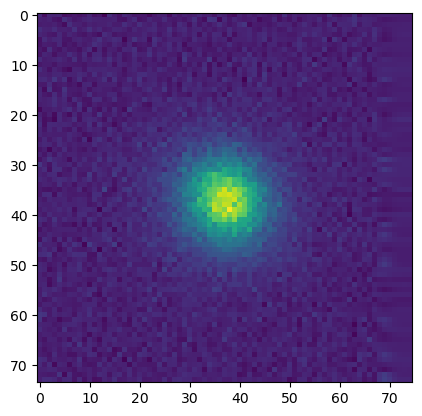

In [21]:
_ = get_star_stats(src,corrected_images[0])

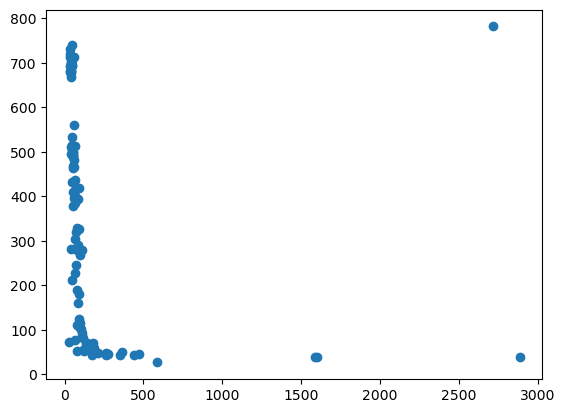

In [22]:
plt.scatter(_[:,0], _[:,1])

In [23]:
len(corrected_images)

10

6.49974
125 0 124
./corrected_image_0.fits Before cut: 121 After cut: 121
13.894898
491 0 490
./corrected_image_1.fits Before cut: 347 After cut: 347
17.253687
695 0 694
./corrected_image_10.fits Before cut: 555 After cut: 555
17.94634
652 0 651
./corrected_image_11.fits Before cut: 515 After cut: 515
8.135548
661 0 660
./corrected_image_12.fits Before cut: 557 After cut: 557
9.986705
595 0 594
./corrected_image_13.fits Before cut: 484 After cut: 484
14.549587
698 0 697
./corrected_image_14.fits Before cut: 599 After cut: 599
14.1794815
143 0 142
./corrected_image_15.fits Before cut: 137 After cut: 137
17.393082
784 0 783
./corrected_image_16.fits Before cut: 620 After cut: 620
17.663662
464 0 463
./corrected_image_17.fits Before cut: 373 After cut: 373
8.224536
607 0 606
./corrected_image_18.fits Before cut: 517 After cut: 517
10.61624
810 0 809
./corrected_image_19.fits Before cut: 641 After cut: 641
8.862789
612 0 611
./corrected_image_2.fits Before cut: 523 After cut: 523
16.964836

IndexError: arrays used as indices must be of integer (or boolean) type

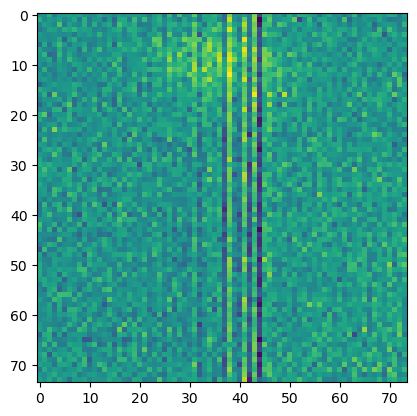

In [27]:
image_list = np.sort(glob.glob("./corrected*.fits"))

#combined_results = process_multiple_images(image_list, corrected_images)
combined_results = np.array([np.nan,np.nan,np.nan,np.nan])
for image_file, image in zip(image_list,corrected_images):

    src = find_stars_in_image(image_file)
    src = remove_blended_sources(src)
    print(image_file, "Before cut:", len(src), "After cut:", len(src))
    result = get_star_stats(src, image)

    combined_results = np.vstack((combined_results, result))

(0.0, 200.0)

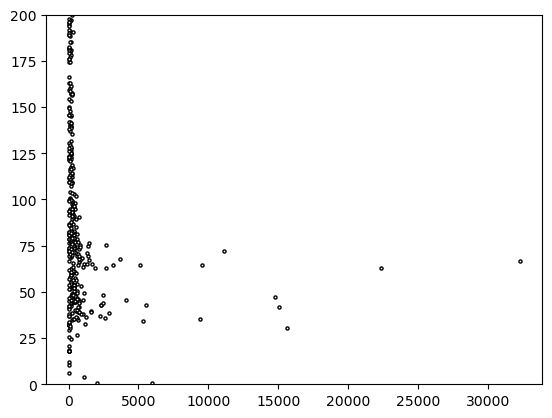

In [31]:
plt.scatter(combined_results[:,0], combined_results[:,1], marker="o", facecolor="white", edgecolor="k", s=5)
#plt.xlim(5000,60000)
plt.ylim(0,200)

In [37]:
src = find_stars_in_image(image_list[10])

8.224536


In [38]:
print(src)

 id xcentroid ycentroid sharpness roundness1 roundness2 npix sky   peak   flux  mag 
--- --------- --------- --------- ---------- ---------- ---- ---- ------ ----- -----
  1    888.31      6.91      0.59      -0.18      -0.22  169 0.00  29.45  1.27 -0.26
  2   1311.23     13.32      0.35       0.17      -0.31  169 0.00  19.39  1.10 -0.10
  3   2580.74     33.95      0.35       0.01      -0.31  169 0.00 225.66  8.81 -2.36
  4   1769.67     34.35      0.85      -0.16      -0.06  169 0.00  69.28  2.31 -0.91
  5   2002.43     39.81      0.45       0.01      -0.33  169 0.00 517.40 20.48 -3.28
  6   2962.55     48.02      0.73      -0.03       0.20  169 0.00  38.15  1.24 -0.24
...       ...       ...       ...        ...        ...  ...  ...    ...   ...   ...
602    754.99   3960.02      0.24       0.33      -0.33  169 0.00  32.99  1.59 -0.51
603   2653.57   3965.15      0.53       0.41      -0.24  169 0.00  12.30  1.08 -0.09
604   1115.16   3967.65      0.25      -0.33       0.15  169 0.00

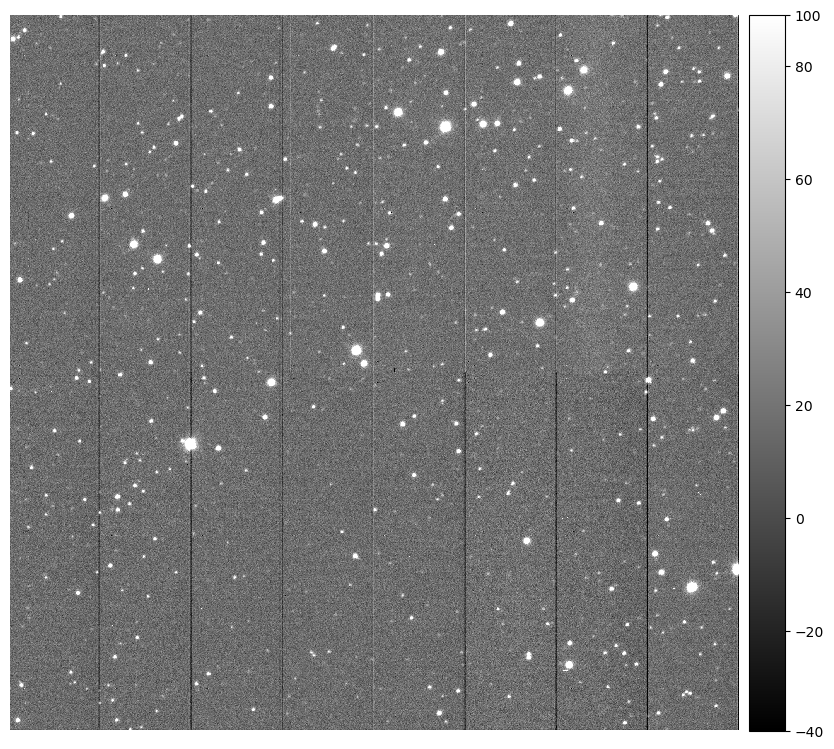

In [36]:
display(corrected_images[10])

FITS standard SkyWcs:
Sky Origin: (240.0097368719, -23.9854066887)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel


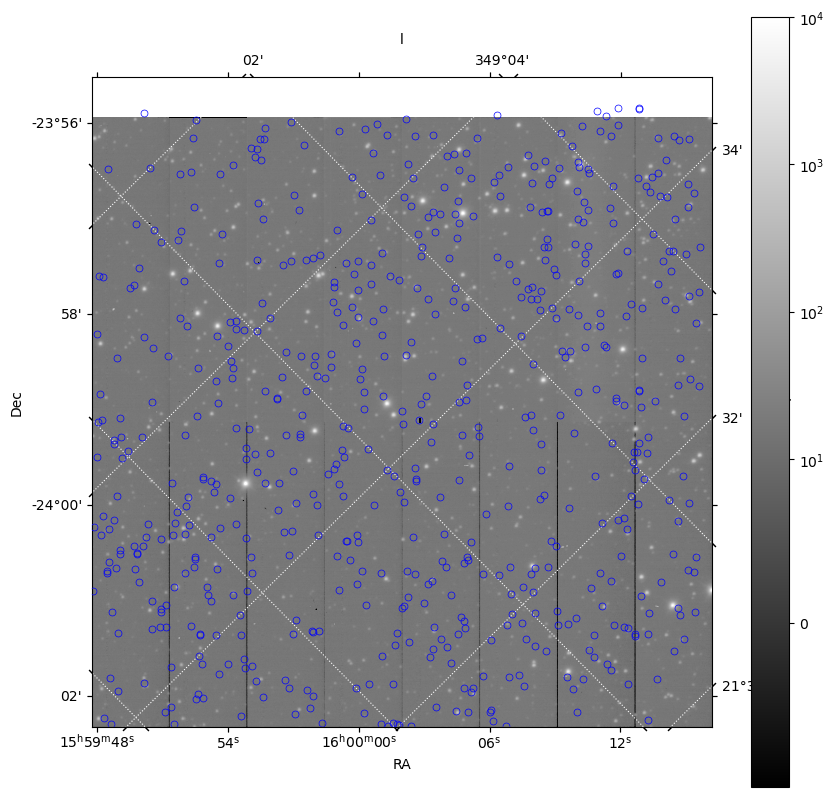

In [40]:
wcs = get_astropy_wcs(corrected_images[0])
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs)
from matplotlib.colors import SymLogNorm
plt.imshow(corrected_images[10].getImage().getArray(), origin='lower', cmap='binary_r', norm=SymLogNorm(10, vmin=-10, vmax=10000, base=10), aspect='equal')
#src = remove_blended_sources(src)
plt.plot(src['ycentroid'], src['xcentroid'], "bo", markerfacecolor='None', markeredgewidth=0.5,markersize=5)
plt.xlabel(r'RA')
plt.ylabel(r'Dec')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.colorbar()
overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='white', ls='dotted')

In [43]:
def find_stars_in_image(image):
    write_image_to_file(image, f"./this_image.fits") 
    from astropy.stats import sigma_clipped_stats
    from photutils.datasets import load_star_image
    from photutils.detection import DAOStarFinder

    hdu = fits.open("./this_image.fits")
    data = hdu[1].data
    mean, median, std = sigma_clipped_stats(image, sigma=3.0) 
    
    print(median)

    daofind = DAOStarFinder(fwhm=10.0, threshold=5.*std)  
    sources = daofind(data - median)  

    for col in sources.colnames:  
        if col not in ('id', 'npix'):
            sources[col].info.format = '%.2f'  # for consistent table output
    
    #sources.pprint(max_width=76)  
    
    return sources

FITS standard SkyWcs:
Sky Origin: (270.2261413204, -25.0446545896)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

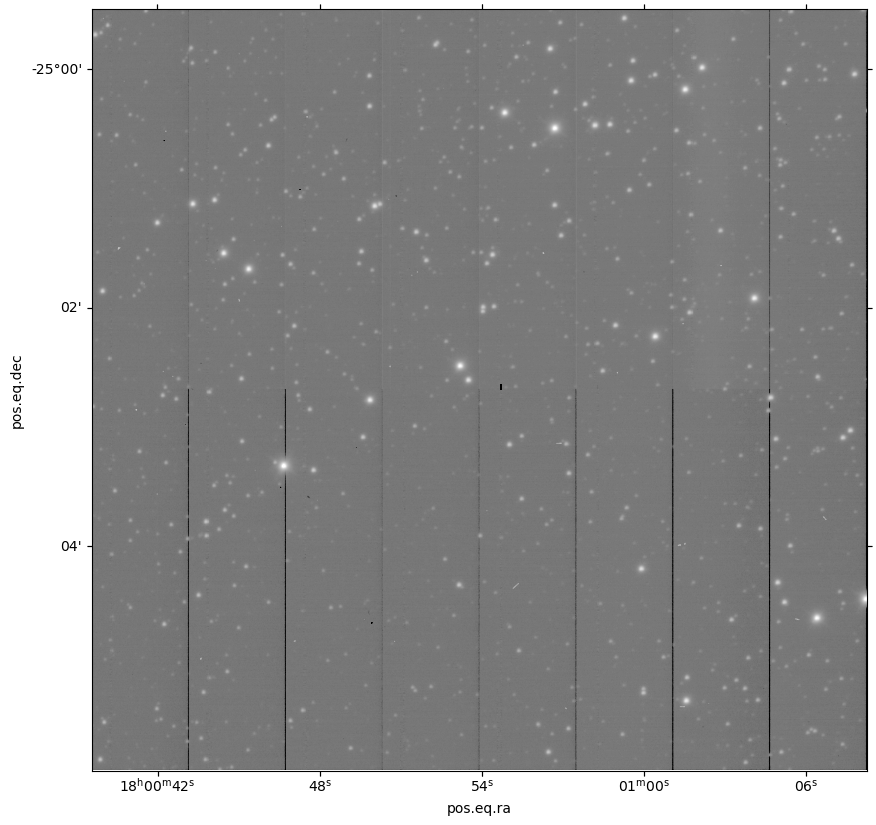

In [44]:
wcs = get_astropy_wcs(corrected_images[10])
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs)
from matplotlib.colors import SymLogNorm
plt.imshow(corrected_images[10].getImage().getArray(), origin='lower', cmap='binary_r', norm=SymLogNorm(10, vmin=-10, vmax=10000, base=10), aspect='equal')
src = find_stars_in_image(corrected_images[10])
#src = remove_blended_sources(src)
plt.plot(src['ycentroid'], src['xcentroid'], "bo", markerfacecolor='None', markeredgewidth=0.5,markersize=5)
plt.xlabel(r'RA')
plt.ylabel(r'Dec')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.colorbar()
overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='white', ls='dotted')